In [12]:
import typing as tp

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import nnx

In [65]:


class CNN(nnx.Module):
    def __init__(self, in_feature: int, out_feature: int, features: tp.Sequence[int], kernel: int, dim: int, padding: str = 'VALID', *, rngs: nnx.Rngs):

        kernel_size = (kernel, ) * dim
        conv_layers = []
        io_features = zip([in_feature, *features], [*features, out_feature])
        for in_f, out_f in io_features:
            l = nnx.Conv(in_features=in_f, out_features=out_f, kernel_size=kernel_size,
                         padding=padding, rngs=rngs)
            conv_layers.append(l)
        self.conv_layers = conv_layers

    def __call__(self, x: jax.Array):
        for l in self.conv_layers:
            x = l(x)
            x = nnx.swish(x)

        return x


class VAE(nnx.Module):
    def __init__(
        self,
        io_features: int,
        latent_feature: int,
        physical_dim: int,
        encoder_features: tp.Sequence[int],
        decoder_features: tp.Sequence[int],
        kernel: int,
        padding: str = 'VALID',
        variational: bool = True,
        *,
        rngs: nnx.Rngs,

    ):
        self.variational = variational
        self.encoder = CNN(in_feature=io_features, out_feature=latent_feature,
                           features=encoder_features, kernel=kernel, dim=physical_dim, padding=padding, rngs=rngs)
        if self.variational:
            assert latent_feature % 2 == 0, 'latent_feature must be devisible by two for variational training'
            decoder_latent = latent_feature // 2
        self.decoder = CNN(in_feature=decoder_latent, out_feature=io_features,
                           features=decoder_features, kernel=kernel, dim=physical_dim, padding=padding, rngs=rngs)

        self.rngs = rngs

    def __call__(self, x: jax.Array) -> jax.Array:
        z = self.encoder(x)

        if self.variational:
            mean, std = jnp.split(z, 2, axis=-1)
            std = jnp.exp(std)
            key = self.rngs.noise()
            z = mean + std * jax.random.normal(key, mean.shape)

        logits = self.decoder(z)
        return logits

In [32]:
from datasets import load_dataset


dataset = load_dataset('mnist')
X_train = np.array(np.stack(dataset['train']['image']), dtype=np.uint8)
X_test = np.array(np.stack(dataset['test']['image']), dtype=np.uint8)
# Now binarize data
X_train = (X_train > 0).astype(jnp.float32)
X_test = (X_test > 0).astype(jnp.float32)



In [66]:
io_features = 1
latent_feature = 4
dim = 2
encoder_features = [32, 16, 8]
decoder_features = [8, 16, 32]
kernel = 2
rngs = nnx.Rngs(0, noise=1)
vae = VAE(io_features=io_features, latent_feature=latent_feature, physical_dim=dim,
          encoder_features=encoder_features, decoder_features=decoder_features, kernel=kernel, rngs=rngs)

In [69]:

batch = X_train[:10]
batch = jnp.expand_dims(batch, axis=-1)

In [71]:
out = vae(batch)

(10, 24, 24, 2) (10, 24, 24, 2)
(10, 24, 24, 2)


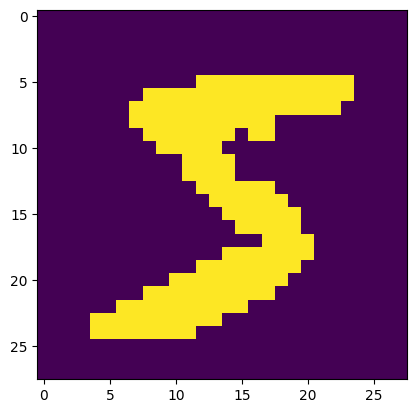

In [72]:
plt.imshow(batch[0])
plt.show()

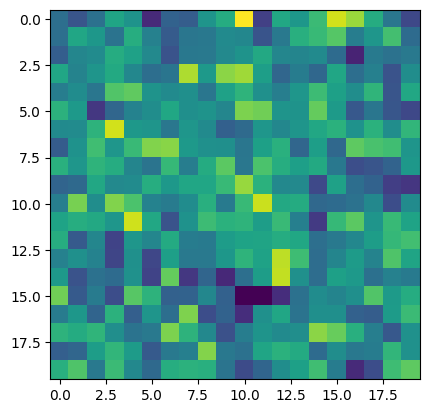

In [73]:
plt.imshow(out[0])
plt.show()